In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

from nn_models import MLP, PSD, DampMatrix
from symoden import SymODEN_R, SymODEN_T, SymODEN_R1_T1
from utils import L2_loss, from_pickle
import gym, myenv

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

DPI = 600
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2


 ## Task 1 configuration

In [2]:
EXPERIMENT_DIR = './experiment-single-force/'
sys.path.append(EXPERIMENT_DIR)
from data import dynamics_fn as single_dynamics
from data import get_dataset as get_single_dataset
sys.path.remove(EXPERIMENT_DIR)
def get_args():
    return {'input_dim': 2,
         'nonlinearity': 'tanh',
         'name': 'pend',
         'gridsize': 10,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 5,
         'gpu': 0,
         'solver': 'dopri5',
         'rad': False,
         'gym': False}

args = ObjectView(get_args())


In [3]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, damping, num_points, gym=False):
    if structure == False and baseline == True:
        nn_model = MLP(args.input_dim, 600, args.input_dim, args.nonlinearity).to(device)    
        model = SymODEN_R(args.input_dim, H_net=nn_model, device=device, baseline=True)
    elif structure == False and baseline == False:
        H_net = MLP(args.input_dim, 400, 1, args.nonlinearity).to(device)
        g_net = MLP(int(args.input_dim/2), 200, int(args.input_dim/2)).to(device)
        model = SymODEN_R(args.input_dim, H_net=H_net, g_net=g_net, device=device, baseline=False)
    elif structure == True and baseline ==False:
        # M_net = MLP(1, args.hidden_dim, 1).to(device)
        M_net = MLP(int(args.input_dim/2), 300, int(args.input_dim/2))
        V_net = MLP(int(args.input_dim/2), 50, 1).to(device)
        g_net = MLP(int(args.input_dim/2), 200, int(args.input_dim/2)).to(device)
        model = SymODEN_R(args.input_dim, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=False, structure=True).to(device)
    else:
        raise RuntimeError('argument *baseline* and *structure* cannot both be true')
    model_name = 'baseline_ode' if baseline else 'hnn_ode'
    struct = '-struct' if structure else ''
    rad = '-rad' if args.rad else ''
    path = '{}pend-{}{}-{}-p{}{}.tar'.format(args.save_dir, model_name, struct, args.solver, num_points, rad)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/pend-{}{}-{}-p{}-stats{}.pkl'.format(args.save_dir, model_name, struct, args.solver, num_points, rad)
    stats = from_pickle(path)
    return model, stats

base_ode_model, base_ode_stats = get_model(args, baseline=True, structure=False, damping=False, num_points=args.num_points, gym=args.gym)
symoden_ode_model, symoden_ode_stats = get_model(args, baseline=False, structure=False, damping=False, num_points=args.num_points, gym=args.gym)
symoden_ode_struct_model, symoden_ode_struct_stats = get_model(args, baseline=False, structure=True, damping=False, num_points=args.num_points, gym=args.gym)


In [4]:
from torchdiffeq import odeint 
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,3).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)


def integrate_models(y0=np.asarray([1, 0]), u0=0.0, t_span=[0,5], t_eval=None):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    y0_u = np.concatenate((y0, np.array([u0])))

    true_path = solve_ivp(fun=single_dynamics, t_span=t_span, y0=y0, **kwargs)
    true_ivp = np.concatenate((true_path['y'], u0 * np.ones((1, time_step))), axis=0)
    true_x = true_ivp.T

    # integrate along baseline vector field
    base_path = integrate_model(base_ode_model, t_span, y0_u, **kwargs)
    base_x = base_path['y'].T

    symoden_path = integrate_model(symoden_ode_model, t_span, y0_u, **kwargs)
    symoden_x = symoden_path['y'].T

    symoden_struct_path = integrate_model(symoden_ode_struct_model, t_span, y0_u, **kwargs)
    symoden_struct_x = symoden_struct_path['y'].T

    return true_x, base_x, symoden_x, symoden_struct_x

time_step = 100
t_span = [0,10]
t_eval_single = np.linspace(t_span[0], t_span[1], time_step) 
init_angle = 2.1
y0 = np.asarray([init_angle, 0])
u0 = 0.0

true_x_single, base_x_single, symoden_x_single, symoden_struct_x_single = integrate_models(y0=y0, u0=u0, t_span=t_span, t_eval=t_eval_single)


In [5]:
def get_energy(x):
    return 1.5 * x[:, 1]**2 + 5 * (1 - np.cos(x[:, 0]))
E_true_single = get_energy(true_x_single)
E_base_single = get_energy(base_x_single)
E_symoden_single = get_energy(symoden_x_single)
E_symoden_struct_single = get_energy(symoden_struct_x_single)


 ## Task 2 configuration

In [6]:
EXPERIMENT_DIR = './experiment-single-embed/'
sys.path.append(EXPERIMENT_DIR)
from data import get_dataset as get_embed_dataset
sys.path.remove(EXPERIMENT_DIR)

def get_args():
    return {'num_angle': 1,
         'nonlinearity': 'tanh',
         'name': 'pend',
         'gridsize': 10,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 5,
         'gpu': 0,
         'solver': 'dopri5'}

args = ObjectView(get_args())


In [7]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, naive, damping, num_points):
    M_net = PSD(2*args.num_angle, 300, args.num_angle).to(device)
    g_net = MLP(2*args.num_angle, 200, args.num_angle).to(device)
    if structure == False:
        if naive and baseline:
            raise RuntimeError('argument *baseline* and *naive* cannot both be true')
        elif naive:
            input_dim = 4 * args.num_angle
            output_dim = 3 * args.num_angle
            nn_model = MLP(input_dim, 800, output_dim, args.nonlinearity).to(device)
            model = SymODEN_T(args.num_angle, H_net=nn_model, device=device, baseline=baseline, naive=naive)
        elif baseline:
            input_dim = 4 * args.num_angle
            output_dim = 2 * args.num_angle
            nn_model = MLP(input_dim, 600, output_dim, args.nonlinearity).to(device)
            model = SymODEN_T(args.num_angle, H_net=nn_model, M_net=M_net, device=device, baseline=baseline, naive=naive)
        else:
            input_dim = 3 * args.num_angle
            output_dim = 1
            nn_model = MLP(input_dim, 500, output_dim, args.nonlinearity).to(device)
            model = SymODEN_T(args.num_angle, H_net=nn_model, M_net=M_net, g_net=g_net, device=device, baseline=baseline, naive=naive)
    elif structure == True and baseline ==False and naive==False:
        V_net = MLP(2*args.num_angle, 50, 1).to(device)
        model = SymODEN_T(args.num_angle, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=baseline, structure=True).to(device)
    else:
        raise RuntimeError('argument *structure* is set to true, no *baseline* or *naive*!')

    if naive:
        label = '-naive_ode'
    elif baseline:
        label = '-baseline_ode'
    else:
        label = '-hnn_ode'
    struct = '-struct' if structure else ''
    path = '{}/{}{}{}-{}-p{}.tar'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/{}{}{}-{}-p{}-stats.pkl'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    stats = from_pickle(path)
    return model, stats

naive_ode_model, naive_ode_stats = get_model(args, baseline=False, structure=False, naive=True, damping=False, num_points=args.num_points)
base_ode_model, base_ode_stats = get_model(args, baseline=True, structure=False, naive=False, damping=False, num_points=args.num_points)
symoden_ode_model, symoden_ode_stats = get_model(args, baseline=False, structure=False, naive=False, damping=False, num_points=args.num_points)
symoden_ode_struct_model, symoden_ode_struct_stats = get_model(args, baseline=False, structure=True, naive=False, damping=False, num_points=args.num_points)

def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,4).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_models(y0=np.asarray([1, 0]), u0=0.0, t_span=[0,5], t_eval=None):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    y0_u = np.concatenate((y0, np.array([u0])))

    # integrate along naive vector field
    naive_path = integrate_model(naive_ode_model, t_span, y0_u, **kwargs)
    naive_x = naive_path['y'].T

    # integrate along baseline vector field
    base_path = integrate_model(base_ode_model, t_span, y0_u, **kwargs)
    base_x = base_path['y'].T

    # integrate along symoden vector field
    symoden_path = integrate_model(symoden_ode_model, t_span, y0_u, **kwargs)
    symoden_x = symoden_path['y'].T

    # integrate along symoden structure vector field
    symoden_struct_path = integrate_model(symoden_ode_struct_model, t_span, y0_u, **kwargs)
    symoden_struct_x = symoden_struct_path['y'].T

    return naive_x, base_x, symoden_x, symoden_struct_x

time_step = 200
t_span = [0, time_step*0.05]
t_eval_embed = np.linspace(t_span[0], t_span[1], time_step)
env = gym.make('MyPendulum-v0')
env.reset()
env.state = np.array([init_angle + np.pi/2, 0.0], dtype=np.float32)
obs = env._get_obs()
obs_list = []
for _ in range(time_step):
    obs_list.append(obs)
    obs, _, _, _ = env.step([u0])

true_ivp = np.stack(obs_list, 1)
true_ivp = np.concatenate((true_ivp, u0 * np.ones((1, time_step))), axis=0)

true_x_embed = true_ivp.T

y0 = np.asarray([np.cos(init_angle + np.pi/2), np.sin(init_angle + np.pi/2), 0])
u0 = 0.0
naive_x_embed, base_x_embed, symoden_x_embed, symoden_struct_x_embed = integrate_models(y0=y0, u0=u0, t_span=t_span, t_eval=t_eval_embed)


In [8]:
def get_energy(x):
    return x[:, 2]**2 / 6 + 5 * (1 + x[:, 0])
E_true_embed = get_energy(true_x_embed)
E_naive_embed = get_energy(naive_x_embed)
E_base_embed = get_energy(base_x_embed)
E_symoden_embed = get_energy(symoden_x_embed)
E_symoden_struct_embed = get_energy(symoden_struct_x_embed)


 ## Task 3 configuration

In [9]:

EXPERIMENT_DIR = './experiment-cartpole-embed/'
sys.path.append(EXPERIMENT_DIR)
from data import get_dataset as get_cart_dataset
sys.path.remove(EXPERIMENT_DIR)

def get_args():
    return {'num_angle': 1,
         'nonlinearity': 'tanh',
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 5,
         'gpu': 2,
         'solver': 'dopri5'}

args = ObjectView(get_args())

def get_model(args, baseline, structure, naive, damping, num_points):
    M_net = PSD(3, 400, 2).to(device)
    g_net = MLP(3, 300, 2).to(device)
    if structure == False:
        if naive and baseline:
            raise RuntimeError('argument *baseline* and *naive* cannot both be true')
        elif naive:
            input_dim = 6
            output_dim = 5
            nn_model = MLP(input_dim, 1000, output_dim, args.nonlinearity).to(device)
            model = SymODEN_R1_T1(args.num_angle, H_net=nn_model, device=device, baseline=baseline, naive=naive)
        elif baseline:
            input_dim = 6
            output_dim = 4
            nn_model = MLP(input_dim, 700, output_dim, args.nonlinearity).to(device)
            model = SymODEN_R1_T1(args.num_angle, H_net=nn_model, M_net=M_net, device=device, baseline=baseline, naive=naive)
        else:
            input_dim = 5
            output_dim = 1
            nn_model = MLP(input_dim, 500, output_dim, args.nonlinearity).to(device)
            model = SymODEN_R1_T1(args.num_angle, H_net=nn_model, M_net=M_net, g_net=g_net, device=device, baseline=baseline, naive=naive)
    elif structure == True and baseline ==False and naive==False:
        V_net = MLP(3, 300, 1).to(device)
        model = SymODEN_R1_T1(args.num_angle, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=baseline, structure=True).to(device)
    else:
        raise RuntimeError('argument *structure* is set to true, no *baseline* or *naive*!')

    if naive:
        label = '-naive_ode'
    elif baseline:
        label = '-baseline_ode'
    else:
        label = '-hnn_ode'
    struct = '-struct' if structure else ''
    path = '{}/{}{}{}-{}-p{}.tar'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/{}{}{}-{}-p{}-stats.pkl'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    stats = from_pickle(path)
    return model, stats

naive_ode_model, naive_ode_stats = get_model(args, baseline=False, structure=False, naive=True, damping=False, num_points=args.num_points)
base_ode_model, base_ode_stats = get_model(args, baseline=True, structure=False, naive=False, damping=False, num_points=args.num_points)
symoden_ode_model, symoden_ode_stats = get_model(args, baseline=False, structure=False, naive=False, damping=False, num_points=args.num_points)
symoden_ode_struct_model, symoden_ode_struct_stats = get_model(args, baseline=False, structure=True, naive=False, damping=False, num_points=args.num_points)

time_step = 500
t_span = [0,time_step*0.02]
t_eval_cart = np.linspace(t_span[0], t_span[1], time_step)

q0 = 1.57
u0 = 0.0
x0 = 0.0
y0 = np.asarray([x0, np.cos(q0), np.sin(q0), 0.0, 0.0])
env = gym.make('MyCartPole-v0')
env.reset()
env.state = np.array([x0, 0.0, q0, 0.0], dtype=np.float32)
obs = env._get_obs()
obs_list = []

for _ in range(time_step):
    obs_list.append(obs)
    obs, _, _, _ = env.step([u0])

true_ivp = np.stack(obs_list, 1)
true_ivp = np.concatenate((true_ivp, u0 * np.ones((1, time_step))), axis=0)
true_x_cart = true_ivp.T

def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,6).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)
naive_x_cart, base_x_cart, symoden_x_cart, symoden_struct_x_cart = integrate_models(y0=y0, u0=u0, t_span=t_span, t_eval=t_eval_cart)


In [10]:
def get_energy(x):
    M = 0.5 ; m = 0.5; l = 1.0
    T = 0.5 * M * x[:, 3]**2 + 0.5 * m * (l*l/4*x[:,4]**2 + x[:,3]**2 + l * x[:,1] * x[:,3] * x[:,4]) + 0.5 * 1/12 * m * l*l * x[:,4]**2
    V = m * 9.8 * 0.5 * l * x[:,1]
    return T+V
E_true_cart = get_energy(true_x_cart)
E_naive_cart = get_energy(naive_x_cart)
E_base_cart = get_energy(base_x_cart)
E_symoden_cart = get_energy(symoden_x_cart)
E_symoden_struct_cart = get_energy(symoden_struct_x_cart)


 ## Task 4 configuration

In [11]:
EXPERIMENT_DIR = './experiment-double-embed/'
sys.path.append(EXPERIMENT_DIR)
from data import get_dataset as get_double_dataset
sys.path.remove(EXPERIMENT_DIR)

def get_args():
    return {'num_angle': 2,
         'nonlinearity': 'tanh',
         'name': 'pend',
         'gridsize': 10,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 5,
         'gpu': 2,
         'solver': 'dopri5'}

args = ObjectView(get_args())

def get_model(args, baseline, structure, naive, damping, num_points):
    M_net = PSD(2*args.num_angle, 400, args.num_angle).to(device)
    g_net = MLP(2*args.num_angle, 300, args.num_angle).to(device)
    if structure == False:
        if naive and baseline:
            raise RuntimeError('argument *baseline* and *naive* cannot both be true')
        elif naive:
            input_dim = 3 * args.num_angle + 1
            output_dim = 3 * args.num_angle
            nn_model = MLP(input_dim, 1200, output_dim, args.nonlinearity).to(device)
            model = SymODEN_T(args.num_angle, H_net=nn_model, device=device, baseline=baseline, naive=naive)
        elif baseline:
            input_dim = 3 * args.num_angle + 1
            output_dim = 2 * args.num_angle
            nn_model = MLP(input_dim, 800, output_dim, args.nonlinearity).to(device)
            model = SymODEN_T(args.num_angle, H_net=nn_model, M_net=M_net, device=device, baseline=baseline, naive=naive)
        else:
            input_dim = 3 * args.num_angle
            output_dim = 1
            nn_model = MLP(input_dim, 600, output_dim, args.nonlinearity).to(device)
            model = SymODEN_T(args.num_angle, H_net=nn_model, M_net=M_net, g_net=g_net, device=device, baseline=baseline, naive=naive)
    elif structure == True and baseline ==False and naive==False:
        V_net = MLP(2*args.num_angle, 300, 1).to(device)
        model = SymODEN_T(args.num_angle, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=baseline, structure=True).to(device)
    else:
        raise RuntimeError('argument *structure* is set to true, no *baseline* or *naive*!')

    if naive:
        label = '-naive_ode'
    elif baseline:
        label = '-baseline_ode'
    else:
        label = '-hnn_ode'
    struct = '-struct' if structure else ''
    path = '{}/{}{}{}-{}-p{}.tar'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/{}{}{}-{}-p{}-stats.pkl'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    stats = from_pickle(path)
    return model, stats

naive_ode_model, naive_ode_stats = get_model(args, baseline=False, structure=False, naive=True, damping=False, num_points=args.num_points)
base_ode_model, base_ode_stats = get_model(args, baseline=True, structure=False, naive=False, damping=False, num_points=args.num_points)
symoden_ode_model, symoden_ode_stats = get_model(args, baseline=False, structure=False, naive=False, damping=False, num_points=args.num_points)
symoden_ode_struct_model, symoden_ode_struct_stats = get_model(args, baseline=False, structure=True, naive=False, damping=False, num_points=args.num_points)


time_step = 200
t_span = [0, time_step*0.05]
t_eval_double = np.linspace(t_span[0], t_span[1], time_step)

q10 = 1.57
q20 = 1.0
# y0 = np.asarray([init_angle, 0])
u0 = 0.0
y0 = np.asarray([np.cos(q10), np.cos(q20), np.sin(q10), np.sin(q20), 0.0, 0.0])

env = gym.make('MyAcrobot-v0')
env.reset()
env.state = np.array([q10, q20, 0.0, 0.0], dtype=np.float32)
obs = env._get_ob()
obs_list = []

for _ in range(time_step):
    obs_list.append(np.array([obs[0], obs[2], obs[1], obs[3], obs[4], obs[5]]))
    obs, _, _, _ = env.step([u0])

true_ivp = np.stack(obs_list, 1)
true_ivp = np.concatenate((true_ivp, u0 * np.ones((1, time_step))), axis=0)

true_x_double = true_ivp.T

def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,3*args.num_angle+1).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

naive_x_double, base_x_double, symoden_x_double, symoden_struct_x_double = integrate_models(y0=y0, u0=u0, t_span=t_span, t_eval=t_eval_double)



 ## Plot

In [12]:
def get_energy(x):
    T = 0.5 * 0.25 * x[:,4]**2 + 0.5 * (x[:,4]**2 + 0.25 * (x[:,4]+x[:,5])**2\
        + x[:,0]*(x[:,0]*x[:,1]-x[:,2]*x[:,3])*x[:,4]*(x[:,4]+x[:,5]) \
        + x[:,2]*(x[:,2]*x[:,1]+x[:,3]*x[:,0])*x[:,4]*(x[:,4]+x[:,5]) ) \
        + 0.5 * 1 * x[:,4]**2 + 0.5 * 1 * (x[:,4]+x[:,5])**2
    V = - 9.8 * x[:,0]/2 - 9.8 * (x[:,0] + 0.5*(x[:,0]*x[:,1]-x[:,2]*x[:,3]))
    return T+V
E_true_double = get_energy(true_x_double)
E_naive_double = get_energy(naive_x_double)
E_base_double = get_energy(base_x_double)
E_symoden_double = get_energy(symoden_x_double)
E_symoden_struct_double = get_energy(symoden_struct_x_double)

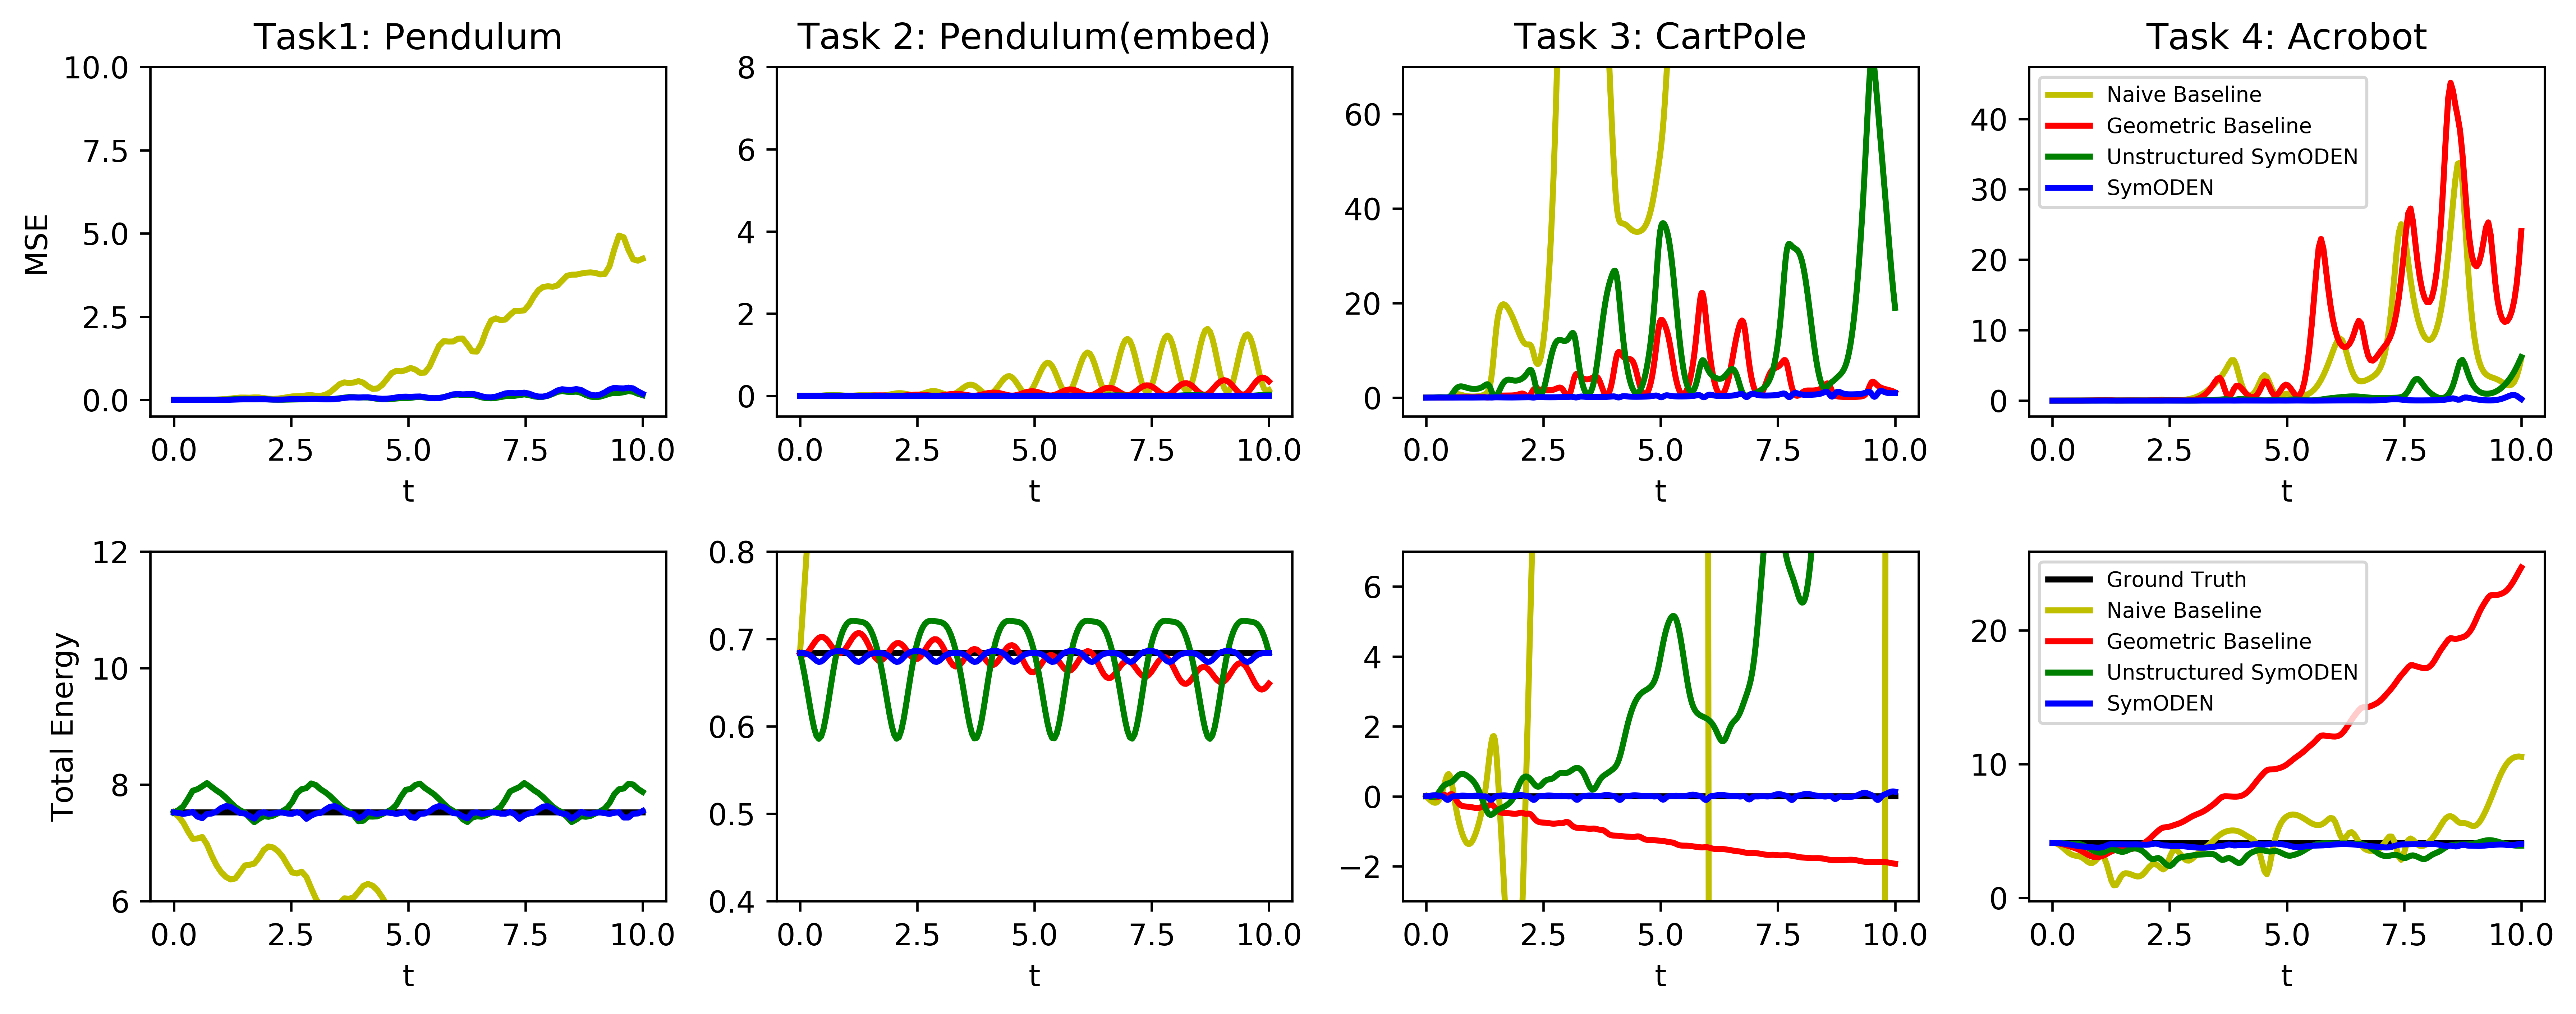

In [13]:
fig = plt.figure(figsize=(12, 4.8), dpi=DPI)
plt.subplot(2, 4, 1)
plt.plot(t_eval_single, ((true_x_single-base_x_single)**2).mean(-1), 'y', linewidth=2)
plt.plot(t_eval_single, ((true_x_single-symoden_x_single)**2).mean(-1), 'g', linewidth=2)
plt.plot(t_eval_single, ((true_x_single-symoden_struct_x_single)**2).mean(-1), 'b', linewidth=2)
plt.ylim(-0.5, 10)
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('Task1: Pendulum')
# plt.legend(fontsize=6)

plt.subplot(2, 4, 2)
plt.plot(t_eval_embed, ((true_x_embed-naive_x_embed)**2).mean(-1), 'y', linewidth=2)
plt.plot(t_eval_embed, ((true_x_embed-base_x_embed)**2).mean(-1), 'r', linewidth=2)
plt.plot(t_eval_embed, ((true_x_embed-symoden_x_embed)**2).mean(-1), 'g', linewidth=2)
plt.plot(t_eval_embed, ((true_x_embed-symoden_struct_x_embed)**2).mean(-1), 'b', linewidth=2)
plt.ylim(-0.5, 8)
plt.xlabel('t')
plt.title('Task 2: Pendulum(embed)')
# plt.legend(fontsize=6)

plt.subplot(2, 4, 3)
plt.plot(t_eval_cart, ((true_x_cart-naive_x_cart)**2).mean(-1), 'y', linewidth=2)
plt.plot(t_eval_cart, ((true_x_cart-base_x_cart)**2).mean(-1), 'r', linewidth=2)
plt.plot(t_eval_cart, ((true_x_cart-symoden_x_cart)**2).mean(-1), 'g', linewidth=2)
plt.plot(t_eval_cart, ((true_x_cart-symoden_struct_x_cart)**2).mean(-1), 'b', linewidth=2)
plt.ylim(-4, 70)
plt.xlabel('t')
plt.title('Task 3: CartPole')
# plt.legend(fontsize=6)

plt.subplot(2, 4, 4)
plt.plot(t_eval_double, ((true_x_double-naive_x_double)**2).mean(-1), 'y', label='Naive Baseline', linewidth=2)
plt.plot(t_eval_double, ((true_x_double-base_x_double)**2).mean(-1), 'r', label='Geometric Baseline', linewidth=2)
plt.plot(t_eval_double, ((true_x_double-symoden_x_double)**2).mean(-1), 'g', label='Unstructured SymODEN', linewidth=2)
plt.plot(t_eval_double, ((true_x_double-symoden_struct_x_double)**2).mean(-1), 'b', label='SymODEN', linewidth=2)
# plt.ylim(-1, 40)
plt.xlabel('t')
plt.title('Task 4: Acrobot')
plt.legend(fontsize=7)

plt.subplot(2, 4, 5)
plt.plot(t_eval_single, E_true_single, 'k', linewidth=2)
plt.plot(t_eval_single, E_base_single, 'y', linewidth=2)
plt.plot(t_eval_single, E_symoden_single, 'g', linewidth=2)
plt.plot(t_eval_single, E_symoden_struct_single, 'b', linewidth=2)
plt.ylim(6, 12)
plt.xlabel('t')
plt.ylabel('Total Energy')
# plt.legend(fontsize=6)

plt.subplot(2, 4, 6)
plt.plot(t_eval_embed, E_true_embed, 'k', linewidth=2)
plt.plot(t_eval_embed, E_naive_embed, 'y', linewidth=2)
plt.plot(t_eval_embed, E_base_embed, 'r', linewidth=2)
plt.plot(t_eval_embed, E_symoden_embed, 'g', linewidth=2)
plt.plot(t_eval_embed, E_symoden_struct_embed, 'b', linewidth=2)
plt.ylim(0.40, 0.8)
plt.xlabel('t')
# plt.legend(fontsize=6)

plt.subplot(2, 4, 7)
plt.plot(t_eval_cart, E_true_cart, 'k', linewidth=2)
plt.plot(t_eval_cart, E_naive_cart, 'y', linewidth=2)
plt.plot(t_eval_cart, E_base_cart, 'r', linewidth=2)
plt.plot(t_eval_cart, E_symoden_cart, 'g', linewidth=2)
plt.plot(t_eval_cart, E_symoden_struct_cart, 'b', linewidth=2)
plt.ylim(-3, 7)
plt.xlabel('t')
# plt.legend(fontsize=6)

plt.subplot(2, 4, 8)
plt.plot(t_eval_double, E_true_double, 'k', label='Ground Truth', linewidth=2)
plt.plot(t_eval_double, E_naive_double, 'y', label='Naive Baseline', linewidth=2)
plt.plot(t_eval_double, E_base_double, 'r', label='Geometric Baseline', linewidth=2)
plt.plot(t_eval_double, E_symoden_double, 'g', label='Unstructured SymODEN', linewidth=2)
plt.plot(t_eval_double, E_symoden_struct_double, 'b', label='SymODEN', linewidth=2)
# plt.ylim(-3, 3)
plt.xlabel('t')
plt.legend(fontsize=7)

plt.tight_layout()
# fig.savefig('{}/fig-MSE-energy.{}'.format(args.fig_dir, FORMAT))
